# 50 оттенков градиентного спуска 

В этом задании вам предстоит реализовать линейный классификатор и натренировать его, используя различные модификации градинетного спуска. Тетрадка позаимствована с [шадовского курса по нейронкам.](https://github.com/yandexdataschool/Practical_DL/blob/master/week01_backprop/adapdive_sgd/adaptive_sgd.ipynb)

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## Генерация выборки

Для наших целей будем использовать искуственно сгенерированные данные.

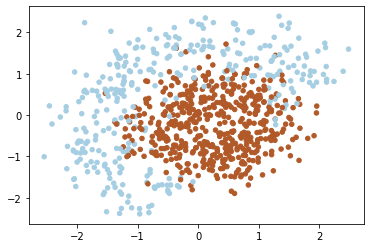

In [2]:
from sklearn import datasets, preprocessing

# keep random_state=42 for deterministic results
(X, y) = datasets.make_circles(n_samples=1024, shuffle=True, noise=0.2, factor=0.4, random_state=42)
ind = np.logical_or(y == 1, X[:, 1] > X[:, 0] - 0.5)
X = X[ind, :]
m = np.array([[1, 1], [-2, 1]])
X = preprocessing.scale(X)
y = y[ind].reshape(-1,1)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, s=20)
plt.show()

### [1] Варка фичей

Как вы можете заметить, данные не являются линейно разделимыми. Нам придётся добавить в обучающую выборку новые фичи либо использовать нелинейные модели. Предположим, что разделяющая поверхность имеет вид окружности. Добавьте в матрицу признаков дополнительные колонки $x_1^2$, $x_2^2$ и $x_1 \cdot x_2$.

In [3]:
def expand(X):
    """
    Добавляет квадратичные фичи. 
    Для каждой строки матрицы находит строку 
    [feature0, feature1, feature0^2, feature1^2, feature0*feature1, 1]
    
    :param X: матрица фичей, shape [n_samples,2]
    :returns: расширенная матрица фичей, shape [n_samples,6]
    """
    X_new = X.copy()
    x1_pow = (X_new[:,0]**2).reshape(-1,1)
    x2_pow = (X_new[:,1]**2).reshape(-1,1)
    x1_x2 = (X_new[:,0]*X_new[:,1]).reshape(-1,1)
    ones = np.ones(X.shape[0]).reshape(-1,1)
    X_new = np.hstack((X_new, x1_pow, x2_pow, x1_x2, ones))
    
    return X_new

### [3] Логистическая регрессия 

Для классификации будем использовать логистическую регрессию. 

$$ a(x; w) = \langle w, x \rangle $$
$$ P( y=1 \; \big| \; x, \, w) = \dfrac{1}{1 + \exp(- \langle w, x \rangle)} = \sigma(\langle w, x \rangle)$$


In [4]:
def probability(X, w):
    """
    Принимает на вход матрицу фичей и вектор весов
    Возвращает предсказание вероятность того, что y = 1 при фиксированных x, P(y=1|x)
    
    :param X: расширенная матрица фичей [n_samples,6] (expanded)
    :param w: вектор весов [6]
    :returns: вектор вероятностей
    """
    def sigmoid(logit):
        return 1/(1+np.exp(-logit))
    
    logit = X.dot(w)
    
    return sigmoid(logit)

Для логистической регрессии оптимальный параметр находится минимизацией кросс-энтропии: 

$$ L(w) =  - {1 \over \ell} \sum_{i=1}^\ell \left[ {y_i \cdot log P(y_i = 1 \, | \, x_i,w) + (1-y_i) \cdot log (1-P(y_i = 1 \, | \, x_i,w))}\right] $$



In [5]:
def compute_loss(X, y, w):
    """
    Принимает на вход матрицу весов, вектор ответов и вектор весов.
    Выдаёт на выход значение функции потерь, расчитанное по формуле выше.
    """
    P = probability(X, w)
    
    loss = y*np.log(P)+(1-y)*np.log(1-P)
    loss = -loss.mean()
    return loss

Мы будем обучать модель методом градиентного спуска. Для этого нам придётся вычислить градиент функции потерь, представленной выше. Возьмите листочек, ручку и в бой! 

$$ \nabla_w L = ...$$

Тут обойдёмся даже без матричного дифириенцирования. А вот в следущий раз его не миновать...

In [6]:
def compute_grad(X, y, w):
    """
    Нахоит значение градиента.
    """
    P = probability(X, w)
#     grad_left = -X.T.dot((y / P) * P * (1 - P))
# #     grad_right = -X.T.dot(((1 - y)/(1 - P))*P*(1-P))
# #     print(grad.shape)
    d_loss_d_P = (-y/P) + ((1-y)/(1-P))
    d_P_d_logit = P*(1-P)
    d_logit_d_w = X
    
    grad = X.T.dot(d_loss_d_P * d_P_d_logit)
    
    
    return grad #grad_left# + grad_right

In [7]:
X_extended = expand(X)
w = np.random.rand(6).reshape(-1,1)
output = probability(X_extended, w)
loss = compute_loss(X_extended, y, w)
grad = compute_grad(X_extended, y, w)

Функция ниже предназначена для визуализации процесса обучения. 

In [8]:
from IPython import display

h = 0.01
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

def visualize(X, y, w, history):
    """С помощью магии matplolib выдаёт красоты результатов классификации"""
    Z = probability(expand(np.c_[xx.ravel(), yy.ravel()]), w)
    Z = Z.reshape(xx.shape)
    plt.subplot(1, 2, 1)
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
    plt.subplot(1, 2, 2)
    plt.plot(history)
    plt.grid()
    plt.xlabel('Iter')
    plt.ylabel('Loss')
    ymin, ymax = plt.ylim()
    plt.ylim(0, ymax)
    display.clear_output(wait=True)
    plt.show()

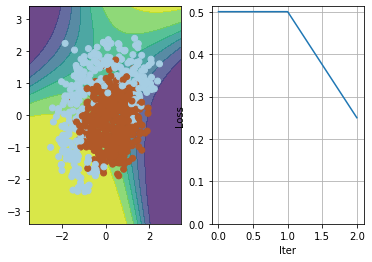

In [9]:
# убедитесь, что у вас она работает, запустив код ниже 
# (он отработает если вы верно реализовали expend и probability)
dummy_weights = np.linspace(-1, 1, 6)
visualize(X, y, dummy_weights, [0.5, 0.5, 0.25])

## Обучение

Пришло время обучить нашу модель. Для этого вам придётся дописать кусочки функций ниже. Обязательно попробуйте поменять гиперпараметры (размер батча и скорость обучения) и посмотреть как будет изменяться анимация. 

In [10]:
X_extended = expand(X)

### [2] Mini-batch SGD

Берём несколько рандомных наблюдений и ищем градиент по ним! 

$$ w_t = w_{t-1} - \eta \dfrac{1}{m} \sum_{j=1}^m \nabla_w L(w_t, x_{i_j}, y_{i_j}) $$



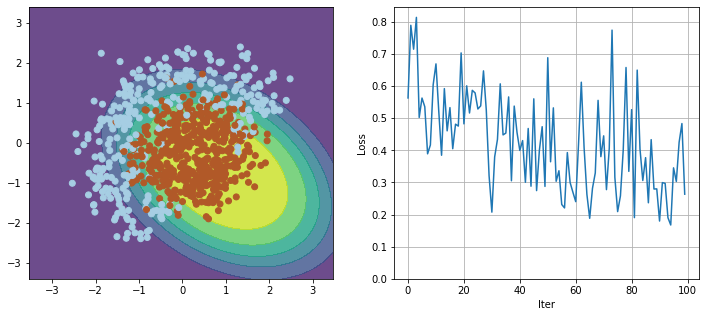

<Figure size 432x288 with 0 Axes>

In [11]:
np.random.seed(42)
w = np.array([0., 0., 0., 0., 0., 1.]).reshape(-1,1)

eta= 0.1 

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12, 5))


for i in range(n_iter):
    batch_index = np.random.choice(X_extended.shape[0], batch_size, False)
    X_batch = X_extended[batch_index,:]
    y_batch = y[batch_index,:]
    
    loss_iter = compute_loss(X_batch, y_batch, w)
    loss[i] = loss_iter
    grad_iter = compute_grad(X_batch, y_batch, w)/batch_size
    
    w -= eta*grad_iter

visualize(X, y, w, loss)
plt.clf()
loss_minibatch = loss.copy()

### [2] Momentum SGD

Momentum это метод, который помогает стохастическому градиентному спуску сохранять направление движения. Это осуществляется за счёт добавления в выражение дополнительного слагаемого: накопленного за предыдущие шаги градиента с весом $\alpha$. 
<br>
<br>

$$ \nu_t = \alpha \nu_{t-1} + \eta\dfrac{1}{m} \sum_{j=1}^m \nabla_w L(w_t, x_{i_j}, y_{i_j}) $$
$$ w_t = w_{t-1} - \nu_t$$


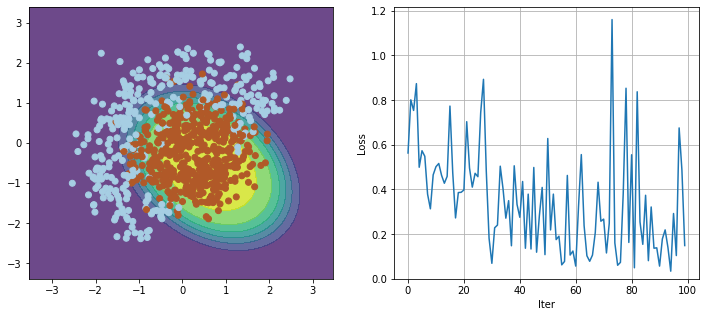

<Figure size 432x288 with 0 Axes>

In [12]:
np.random.seed(42)
w = np.array([0., 0., 0., 0., 0., 1.]).reshape(-1,1)

eta = 0.05 
alpha = 0.9 
nu = np.zeros_like(w).reshape(-1,1)

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12, 5))

for i in range(n_iter):
    batch_index = np.random.choice(X_extended.shape[0], batch_size, False)
    X_batch = X_extended[batch_index,:]
    y_batch = y[batch_index,:]
    
    loss_iter = compute_loss(X_batch, y_batch, w)
    loss[i] = loss_iter
    grad_iter = compute_grad(X_batch, y_batch, w)/batch_size
    
    nu = alpha*nu + eta*grad_iter
    w -= nu
    

visualize(X, y, w, loss)
plt.clf()
loss_momentum = loss.copy()

### [2] RMSprop

В этом блоке реализуем RMSprop. Эта вариация градиентного спуска позволяет изменять скорость обучения индивидуально для каждого параметра. 

$$ G_t^j = \alpha G_{t-1}^j + (1 - \alpha) g_{tj}^2 $$
$$ w_t^j = w_{t-1}^j - \dfrac{\eta}{\sqrt{G_t^j + \varepsilon}} g_{tj} $$

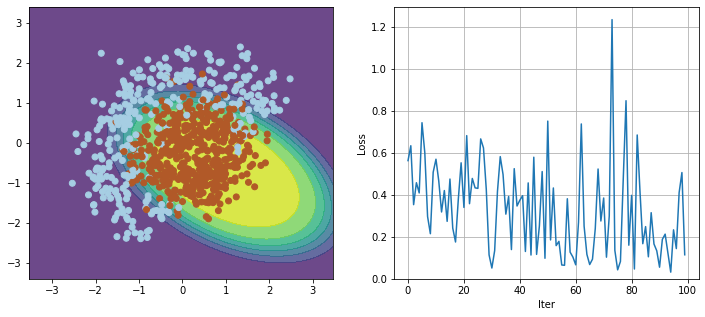

<Figure size 432x288 with 0 Axes>

In [13]:
np.random.seed(42)

w = np.array([0., 0., 0., 0., 0., 1.]).reshape(-1, 1)

eta = 0.1 
alpha = 0.9 
g2 = np.zeros_like(w)
eps = 1e-8

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))

for i in range(n_iter):
    batch_index = np.random.choice(X_extended.shape[0], batch_size, False)
    X_batch = X_extended[batch_index, :]
    y_batch = y[batch_index, :]
    
    loss_iter = compute_loss(X_batch, y_batch, w)
    loss[i] = loss_iter
    grad_iter = compute_grad(X_batch, y_batch, w) / batch_size
    
    g2 = alpha * g2 + (1-alpha) * (grad_iter**2)
    w -= eta * grad_iter / np.sqrt(g2 + eps)

visualize(X, y, w, loss)
plt.clf()

loss_rmsprop = loss.copy()

Как траектории обучения различных вариаций градиентного спуска различаются между собой? Ожидаемо ли это? Почему? Что нужно сделать, чтобы реализовать Adam? 

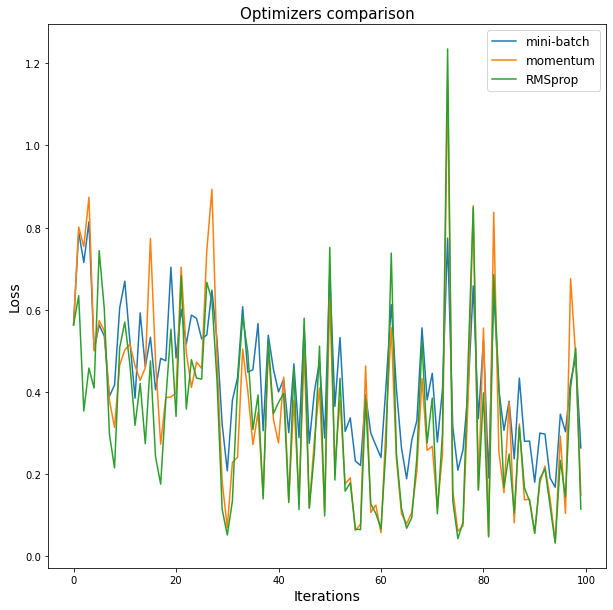

In [20]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.plot(loss_minibatch, label='mini-batch')
ax.plot(loss_momentum, label='momentum')
ax.plot(loss_rmsprop, label='RMSprop')
ax.set_xlabel('Iterations', fontsize=14)
ax.set_ylabel('Loss', fontsize=14)
ax.legend(fontsize=12)
ax.set_title('Optimizers comparison', fontsize=15);

Траектории различаются по амплитуде функции потерь. То есть накомпленные градиенты в momentum и RMSprop смещают вектор градиента сильнее в стороны. При аналогии с шариком, скорость его перемещения более быстрая. Да, это ожидаемое явление и как раз то, что и хотели получить от этих методов оптимизации. RMSprop на этих данных дает практически на каждом шаге наименьший loss из всех 3х методов оптимизации. Adam написан ниже =)

### [2] За каждую адекватную вариацию

Если понравилось реализовывать свои градиентные спуски и ты находишься от них под глубоким впечатлением, я могу накинуть два дополнительных балла за реализацию каждой новой адекватной вариации. 

### Adam

$$ h_t^j = \beta_1 \cdot h_{t-1}^j + (1-\beta_1) \cdot g_{tj}$$
$$ G_t^j = \beta_2 \cdot G_{t-1}^j + (1-\beta_2) \cdot g_{tj}^2$$
$$ w_t^j = w_{t-1}^j - \frac{\eta_t}{\sqrt{G_t^j + \epsilon}} \cdot h_t^j $$

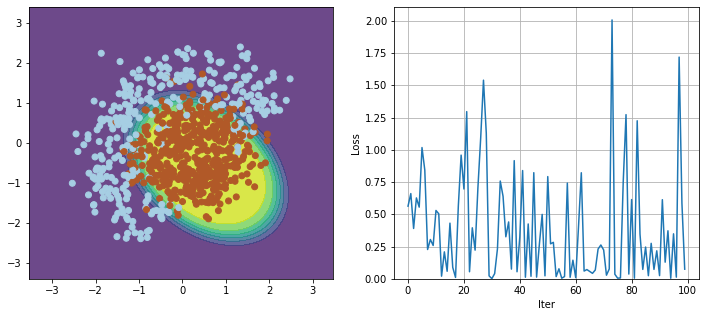

<Figure size 432x288 with 0 Axes>

In [15]:
np.random.seed(42)

w = np.array([0., 0., 0., 0., 0., 1.]).reshape(-1, 1)

eta = 0.1 
beta_1 = 0.9
beta_2 = 0.999
h = np.zeros_like(w)
G = np.zeros_like(w)
eps = 1e-8

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))

for i in range(n_iter):
    batch_index = np.random.choice(X_extended.shape[0], batch_size, False)
    X_batch = X_extended[batch_index, :]
    y_batch = y[batch_index, :]
    
    loss_iter = compute_loss(X_batch, y_batch, w)
    loss[i] = loss_iter
    grad_iter = compute_grad(X_batch, y_batch, w) / batch_size
    
    h = beta_1 * h + (1 - beta_1) * grad_iter
    G = beta_2 * G + (1 - beta_2) * grad_iter**2
    w -= eta * h / np.sqrt(G + eps)

visualize(X, y, w, loss)
plt.clf()

loss_adam = loss.copy()

### AdaGrad

$$ G_t^j = G_{t-1}^j + g_{tj}^2 $$
$$ w_t^j = w_{t-1}^j - \dfrac{\eta}{\sqrt{G_t^j + \varepsilon}} g_{tj} $$

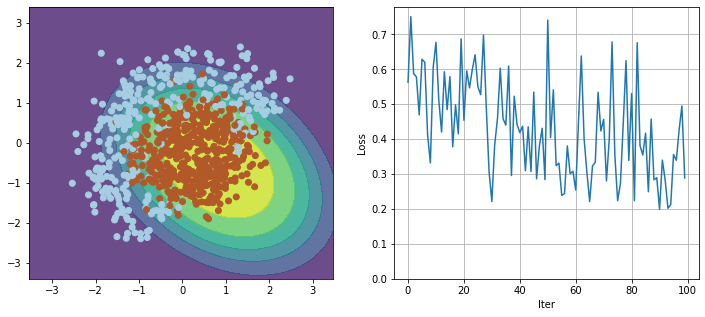

<Figure size 432x288 with 0 Axes>

In [18]:
np.random.seed(42)

w = np.array([0., 0., 0., 0., 0., 1.]).reshape(-1, 1)

eta = 0.1 
g2 = np.zeros_like(w)
eps = 1e-8

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))

for i in range(n_iter):
    batch_index = np.random.choice(X_extended.shape[0], batch_size, False)
    X_batch = X_extended[batch_index, :]
    y_batch = y[batch_index, :]
    
    loss_iter = compute_loss(X_batch, y_batch, w)
    loss[i] = loss_iter
    grad_iter = compute_grad(X_batch, y_batch, w) / batch_size
    
    g2 = g2 + (grad_iter**2)
    w -= eta * grad_iter / np.sqrt(g2 + eps)

visualize(X, y, w, loss)
plt.clf()

loss_adagrad = loss.copy()

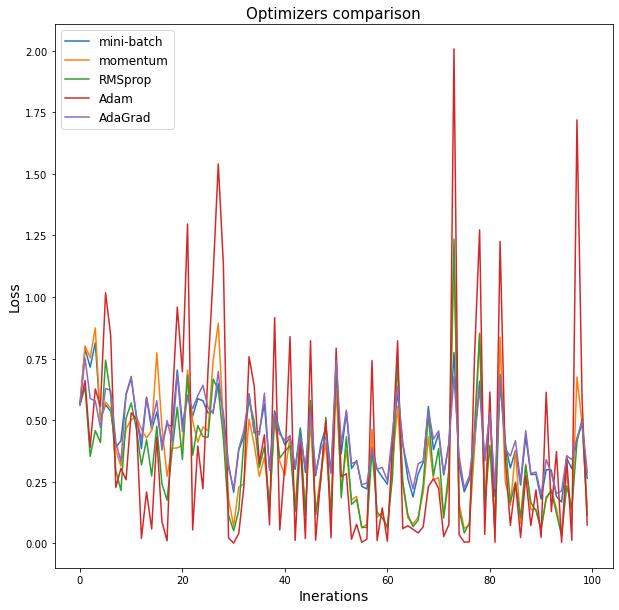

In [19]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.plot(loss_minibatch, label='mini-batch')
ax.plot(loss_momentum, label='momentum')
ax.plot(loss_rmsprop, label='RMSprop')
ax.plot(loss_adam, label='Adam')
ax.plot(loss_adagrad, label='AdaGrad')
ax.set_xlabel('Inerations', fontsize=14)
ax.set_ylabel('Loss', fontsize=14)
ax.legend(fontsize=12)
ax.set_title('Optimizers comparison', fontsize=15);